# Dashboard zur Auswertung von Rezepten

Grundlage sind die Datenbank Spoonacular sowie der Subreddit "food"

### Use Cases:
##### Reddit:
1. Postzeit (Uhrzeit) der besten Posts
2. Postzeit (Uhrzeit) der schlechtesten Posts
3. längste Zeit in Top
4. kürzeste Zeit in Top(?)
5. Länge des Titels in Bezug auf Ups/Dauer in Top
6. Kategorisierung mit NLP bzgl. Süß/Herzhaftes Gericht
7. Kategorisierung mit Bilderkennung bzgl. Süß/Herzhaftes Gericht
8. Up’s abhängig von Autor
9. Anzahl der Kommentare in Abhängigkeit von Ups
10. Anzahl der Kommentare in Abhängigkeit von Postzeit
11. Anzahl der Kommentare in Abhängigkeit von Autor
12. Anzahl der Kommentare über die Zeit
13. Anzahl der Ups über die Zeit
14. Kommentare: 
    1. Beziehung zwischen Personen erkennen/clustern


    
##### Spoonacular:
15. Anteil vegane/vegetarische/fleischlastige Gerichte
16. Anteil laktosefreie Gerichte
17. Anteil glutenfreier Gerichte
18. Bewertung im Verhältnis zu Inhaltsstoffen
    1. Zucker    
    2. Fett
    3. Kalorien
19. Zubereitungszeit in Abhängigkeit von Likes
20. Kategorisierung aufgrund von Inhaltsstoffen
21. Zubereitungszeit in Abhängigkeit von Kategorie 


##### Kombi:
22. Kombi aus Spoonacular Nr. 17 und Top 10 der letzten 24h
23. Vergleich der Beliebtheit der Rezepte: Spoonacular Likes vs. Reddit Ups


## Requirements

In [1]:
# Final Variablen
API_KEY_SPOONACULAR = "146fe79a630b4afb8306a2985bedc64c"
API_KEY_SPOONACULAR = "6e0a91c81983423792b327bc4b78bb1d"

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"

In [2]:
# KONFIGURATION

LIMIT_REDDIT_POSTS = 100
LIMIT_SPOONACULAR_RECIPES = 100
REDDIT_SAVE_INTERVALL = 10 # Minuten

In [3]:
# Auf Windows ausführen (einmalig)
# !pip install praw
# !pip install pandas
# !pip install matplotlib
# !pip install mysql-connector-python

In [4]:
# Auf Linux ausführen (einmalig)
"""
!pip3 install praw
!pip3 install pandas
!pip3 install matplotlib
!pip3 install mysql-connector-python
"""

'\n!pip3 install praw\n!pip3 install pandas\n!pip3 install matplotlib\n!pip3 install mysql-connector-python\n'

In [5]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

### Connect to Database

In [6]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [7]:
cursor = db_connection.cursor()

In [8]:
db_connection.commit()

In [9]:
cursor.execute("select count(id) from reddit")

In [10]:
for blub in cursor:
    print(blub[0])

793100


### Get Data from Subreddit DB

In [11]:
dfr = pd.read_sql("SELECT * FROM reddit", db_connection)

### Get Data from Spoonacular DB

In [12]:
dfs = pd.read_sql("SELECT * FROM spoonacular", db_connection)

In [13]:
dfr.tail()

,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time
793095,821507,08,08:36:41,2021-04-09,yhzm,[Homemade] Koshari - Egypt's national dish,45,0,16,,https://b.thumbs.redditmedia.com/EBxP5H1IRjH3H...,https://i.redd.it/xgkt1nc211s61.jpg,2021-04-09 15:10:05.747406
793096,821508,18,18:11:25,2021-04-09,WelshOkie,[homemade] Eggplant Parm!,10,0,0,,https://b.thumbs.redditmedia.com/5a06L0QXiZixW...,https://i.redd.it/e26399i0w3s61.jpg,2021-04-09 15:10:05.749177
793097,821509,11,11:23:03,2021-04-09,hahayes234,"NY Strip steak, asparagus and potatoes [homemade]",27,0,4,,https://a.thumbs.redditmedia.com/cHPeDbrlf1VSA...,https://i.redd.it/s023xo85v1s61.jpg,2021-04-09 15:10:05.750932
793098,821510,14,14:16:34,2021-04-09,Acceptable_West_3871,[homemade] Seared Duck Breast w/ Cherry-Port R...,16,0,1,,https://a.thumbs.redditmedia.com/yu2EyDJqk74VR...,https://i.redd.it/hd13vfy3q2s61.jpg,2021-04-09 15:10:05.752702
793099,821511,20,20:19:07,2021-04-09,No-Ad-322,[Homemade]Double smash burgers with fried onions,6,0,0,,https://b.thumbs.redditmedia.com/7E1gU_ri9GwLy...,https://i.redd.it/mdqa40lsi4s61.jpg,2021-04-09 15:10:05.754498


### 1. Postzeit der besten Posts (0.9 Quantil)

In [19]:
dfr_wd = dfr[["title", "ups", "time_created", "hour_created", "num_comments", "author"]]
dfr_wds = dfr_wd.sort_values("ups", ascending=False)
dfr_wods = dfr_wds.drop_duplicates(subset=["title"]).copy()
dfr_wods["time"] = pd.to_datetime(dfr_wods["time_created"])
dfr_wodss = dfr_wods[(dfr_wods["ups"]>dfr_wods["ups"].quantile(0.9))].copy()
dfr_wodsl = dfr_wods[dfr_wods["ups"]<dfr_wods["ups"].quantile(0.1)].copy()
hour_dict = dfr_wodss.value_counts(subset=["hour_created"]).to_dict()
#hour_dict

In [ ]:
testdf = dfr_wd[["time_created", "title"]].copy()
testdf.drop_duplicates(subset=["title"], inplace=True)
print(testdf.describe())
#testdf.reset_index(testdf["time_created"], inplace=True)
testdf.head()

In [ ]:
testdf = pd.to_datetime(dfr_wods["time_created"])

testdf = testdf.resample('d').first() 

#Take the moving mean with window size of 45 days 
testdf = testdf.rolling(window=45, min_periods=0).mean() 

In [ ]:
import numpy as np
x = moving_average(vals)

In [17]:
vals = sorted(dfr_wods["time_created"].value_counts().to_dict().items())
h = []
c = []
for pair in vals:
    h.append(pair[0])
    c.append(pair[1])
h = pd.to_datetime(h)

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

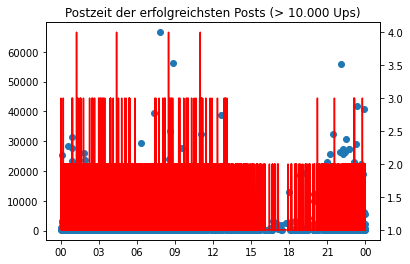

In [18]:
myFmt = pdt.DateFormatter('%H')

fig,ax=plt.subplots()
ax.scatter(dfr_wodss["time"], dfr_wodss["ups"])
ax2 = ax.twinx()
ax2.plot(h, c, c='r')

plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der erfolgreichsten Posts (> 10.000 Ups)")
ax.xlabel("Postzeit in Stunden")
ax.ylabel("Ups")
ax.yticks([0,10000,20000,30000,40000,50000,60000])

ax2.ylabel("Anzahl Posts")
plt.show()

In [48]:
pd.to_numeric(dfr_wodsl["hour_created"])
print(range(24))

range(0, 24)


### 2. Postzeit Beste (>0.9 Quantil) vs Schlechteste (<0.1 Quantil) Posts

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


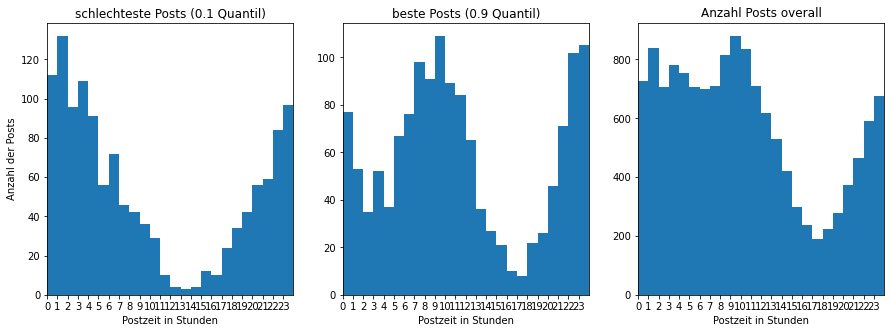

In [75]:
#plt.scatter(dfr_wodsl["time"], dfr_wodsl["ups"])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(15,5))

ax1.set_title("schlechteste Posts (0.1 Quantil)")
ax1.hist(pd.to_numeric(dfr_wodsl["hour_created"]), bins=range(25))
ax1.set_xlabel("Postzeit in Stunden")
ax1.set_xticks(range(24))
ax1.set_xlim([0,24])
ax1.set_ylabel("Anzahl der Posts")

ax2.set_title("beste Posts (0.9 Quantil)")
ax2.hist(pd.to_numeric(dfr_wodss["hour_created"]), bins=range(25))
ax2.set_xlabel("Postzeit in Stunden")
ax2.set_xticks(range(24))
ax2.set_xlim([0,24])

ax3.set_title("Anzahl Posts overall")
ax3.hist(pd.to_numeric(dfr_wods["hour_created"]), bins=range(25))
ax3.set_xlabel("Postzeit in Stunden")
ax3.set_xticks(range(24))
ax3.set_xlim([0,24])

fig.show()

### 3. längste Zeit in Top

In [76]:
dfr_wdg = dfr_wd.groupby("title")
pairs = dfr_wdg.groups

In [68]:
posts = []
for key in pairs:
    posts.append(dfr_wdg.get_group(key)[["time_created", "title", "ups"]].to_dict())

In [69]:
for post in posts:
    post["duration"] = len(post["time_created"]) * REDDIT_SAVE_INTERVALL


In [70]:
duration = []
for post in posts:
    duration.append([list(post["title"].values())[0], 
                     post["duration"], 
                     max(list(post["ups"].values())), 
                     list(post["time_created"].values())[0]])
dfrd = pd.DataFrame(duration, 
                    columns=["title", 
                             "duration_minutes", 
                             "max_ups", 
                             "time_created"])
dfrd_s = dfrd.sort_values("duration_minutes", ascending=False)
dfrd_s["posttime"] = pd.to_datetime(dfrd_s["time_created"])
dfrd_s.head()

,title,duration_minutes,max_ups,time_created,posttime
5980,[Homemade] Pizza,19870,18016,07:29:14,2021-04-09 07:29:14
2666,[Homemade] Chocolate Chip Cookies,15040,19340,07:09:46,2021-04-09 07:09:46
4755,[Homemade] Lasagna,10920,1063,15:15:19,2021-04-09 15:15:19
2221,[Homemade] Cheeseburger,9900,1665,08:51:53,2021-04-09 08:51:53
1495,[Homemade] Birria Tacos,9280,9322,11:35:57,2021-04-09 11:35:57


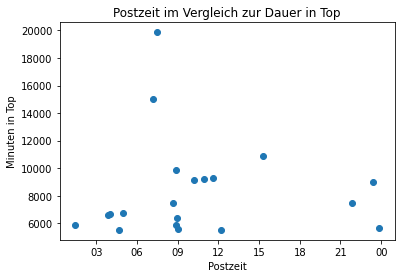

In [71]:
limit = 20
plt.scatter(dfrd_s["posttime"][:limit], dfrd_s["duration_minutes"][:limit])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xlabel("Postzeit")
plt.ylabel("Minuten in Top")
plt.show()

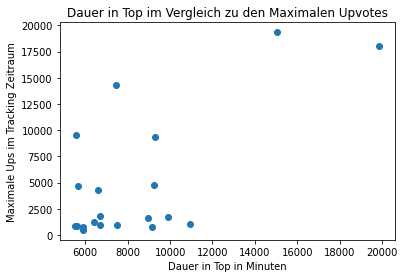

In [72]:
#limit = 20 #nur wenn nochmal verändert werden soll
plt.scatter(dfrd_s["duration_minutes"][:limit], dfrd_s["max_ups"][:limit])
plt.title("Dauer in Top im Vergleich zu den Maximalen Upvotes")
plt.xlabel("Dauer in Top in Minuten")
plt.ylabel("Maximale Ups im Tracking Zeitraum")
plt.show()

### 4. Kürzeste Zeit in Top

In [ ]:
dfrd_s[dfrd_s["duration_minutes"] == 10].describe()

In [ ]:
plt.hist(dfrd_s[dfrd_s["duration_minutes"]==10]["max_ups"])
plt.title("Ups der Posts mit der kürzesten Zeit")
plt.xlabel("Max Ups")
plt.ylabel("Anzahl der Posts")
plt.show()

In [ ]:
limit = 111
plt.scatter(dfrd_s["posttime"][-limit:], dfrd_s["max_ups"][-limit:])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der Top = 10min im Vergleich der Ups")
plt.xlabel("Postzeit")
plt.ylabel("Max Upvotes")
plt.yticks([x for x in range(1,20,3)])
plt.show()

### 5.1 Länge des Titels in Bezug auf Ups

In [ ]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)

In [ ]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["title_length"], 
           dfr_wods[dfr_wods["ups"]>limit]["ups"])
plt.title("Länge des Titels im Vergleich zu Upvotes (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Ups")
plt.show()

### 5.2. Länge des Titels in Bezug auf Dauer in Top

In [ ]:
dfrd_s["title_length"] = dfrd_s["title"].apply(len)

In [ ]:
limit = 500
plt.scatter(dfrd_s[dfrd_s["max_ups"]>limit]["title_length"], 
           dfrd_s[dfrd_s["max_ups"]>limit]["duration_minutes"])
plt.title("Länge des Titels im Vergleich zu Dauer in Top (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Dauer in Top")
plt.show()

### 6. Kategorisierung bzgl. Süß/Herzhaft (NLP)

In [ ]:
# von Alex in dedizierten File

### 7. Kategorisierung bzgl. Süß/Herzhaft (Bilderkennung)

### 8. Ups abhängig vom Autor

In [ ]:
author_dict = dfr_wods.value_counts(subset=["author"]).to_dict()

In [ ]:
authors = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].sum()]
    authors.append(author)

In [ ]:
dfa = pd.DataFrame(authors, columns=["author", "posts", "ups"])
dfa_s = dfa.sort_values("ups", ascending=False)
dfa_s.head()
dfa_ss = dfa_s[dfa_s["ups"]> 10000]

In [ ]:
plt.bar(dfa_ss["author"], dfa_ss["ups"])
plt.xticks(rotation='vertical')
plt.title("Ups abhängig vom Autor, Autoren mit > 10.000 Ups gesamt")
plt.ylabel("Ups")
plt.show()

### 8.1. Anzahl Posts pro Autor in Abhängigkeit der Ups gesamt

In [ ]:
plt.scatter(dfa_s["posts"], dfa_s["ups"])
plt.xlabel("Posts")
plt.ylabel("Ups")
plt.title("Verhältnis Posts zu Ups")
plt.show()

### 9. Anzahl Kommentare in Abhängigkeit von Ups

In [ ]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["ups"],
           dfr_wods[dfr_wods["ups"]>limit]["num_comments"])
plt.title("Kommentare in Abhängigkeit von Ups. Posts >"+ str(limit) + " Upvotes")
plt.xlabel("Ups")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 10. Anzahl Kommentare in Abhängigkeit von Postzeit

In [ ]:
limit = 100
plt.scatter(dfr_wods[dfr_wods["num_comments"]>limit]["time"],
           dfr_wods[dfr_wods["num_comments"]>limit]["num_comments"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Anzahl Kommentare in Abhängigkeit von Postzeit. Posts >" + str(limit) + " Kommentare")
plt.xlabel("Postzeit")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 11. Anzahl Kommentare in Abhängigkeit vom Autor

In [ ]:
authors2 = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].max(),
             dfr_wods[dfr_wods["author"]==key[0]]["num_comments"].max()]
    authors2.append(author)

In [ ]:
authors2[0]

In [ ]:
dfa2 = pd.DataFrame(authors2, columns=["author", "posts", "ups", "num_comments"])
dfa2_s = dfa2.sort_values("num_comments", ascending=False)

In [ ]:
limit = 100
plt.bar(dfa2_s[dfa2_s["num_comments"]>limit]["author"], 
        dfa2_s[dfa2_s["num_comments"]>limit]["num_comments"])
plt.xticks(rotation='vertical')
plt.title("Kommentare abhängig vom Autor. Posts mit >" + str(limit) + " Kommentaren")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 12. Anzahl Kommentare über die Zeit

In [ ]:
dfr["time"] = pd.to_datetime(dfr["curr_time"])
critical_date = datetime.now() - timedelta(days=14)

In [ ]:
plt.plot(dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["time"],
        dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["num_comments"])
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))
for i in range(n):
   c=next(color)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

# --------------------
# Spoonacular
# --------------------
### 16. Anteil vegane/vegetarische/fleischhaltige Gerichte

In [ ]:
dfs_wod = dfs.drop_duplicates(subset=["url"])

In [ ]:
parts = dfs_wod[["vegetarian", "vegan"]].sum()

In [ ]:
fges = dfs_wod["vegetarian"].count()
fvegn = dfs_wod["vegan"].sum()
fvegt = dfs_wod["vegetarian"].sum() - fvegn
frest = fges - fvegt - fvegn

In [ ]:
plt.pie([fvegn, fvegt, frest], 
        labels=["Vegan", "Vegetarisch", "Rest"],
       autopct='%1.1f%%', explode=(0.1,0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Essensrichtung der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 17. Anteil laktosefreie Gerichte

In [ ]:
plt.pie([dfs_wod["dairy_free"].sum(), 
         dfs_wod["dairy_free"].count() - dfs_wod["dairy_free"].sum()], 
        labels=["Laktosefrei", "Nicht Laktosefrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Laktosefreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 18. Anteil glutenfreier Gerichte

In [ ]:
plt.pie([dfs_wod["gluten_free"].sum(), 
         dfs_wod["gluten_free"].count() - dfs_wod["gluten_free"].sum()], 
        labels=["Glutenfrei", "Nicht Glutenfrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Glutenfreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["gluten_free"].count()))
plt.show()

In [ ]:
def filter_category(data):
    counter = {}
    for word in data:
        end = False
        w = ""
        word = word[0].lower()
        for ch in word:
            if end == False:
                if ch == "[":
                    w = w + ch
                elif ch == "]":
                    w = w+ ch
                    end = True
                else:
                    w = w + ch
        if len(w) > 1:
            if w[0] == "[":
                try:
                    counter[w] = counter[w] + 1
                except:
                    counter[w] = 1
    return counter

In [ ]:
x = filter_category(data)

In [ ]:
x

# Reddit Stuff mit Autoren

In [ ]:
autoren = dfr[["author", "ups", "title", "time_created"]].drop_duplicates(subset=["author"]).copy()

In [ ]:
autoren.head()

In [ ]:
reddit = praw.Reddit(client_id = API_CLIENTID_REDDIT,
                    client_secret = API_KEY_REDDIT,
                    username= USERNAME_REDDIT,
                    password = PW_REDDIT,
                    user_agent = "food_dashboard_v01")

subreddit = reddit.subreddit("food")

In [ ]:
user = reddit.redditor("daynestxbbq")

In [ ]:
time_created = user.created_utc

In [ ]:
mod = user.is_mod
employee = user.is_employee

In [ ]:
datetime.fromtimestamp(time_created).strftime('%Y-%m-%d')

In [ ]:
df_user = pd.DataFrame(data={}, columns=["user", "created", "moderator", "employee", "karma"])

In [ ]:
def get_userdata_from_username(username, df_user):
    user = reddit.redditor(username)
    account_created = datetime.fromtimestamp(user.created_utc).strftime('%Y-%m-%d')
    is_mod = user.is_mod
    is_employee = user.is_employee
    link_karma = user.link_karma
    new_row = {"user": username, "created": account_created, "moderator": is_mod, "employee": is_employee, "karma": link_karma}
    df_user = df_user.append(new_row, ignore_index=True)
    time.sleep(5)
    return df_user

In [ ]:
df_user = get_userdata_from_username("daynestxbbq", df_user)
df_user

In [ ]:
import praw
import pandas as pd
import time
from tqdm import tqdm

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"


reddit = praw.Reddit(client_id = API_CLIENTID_REDDIT,
                    client_secret = API_KEY_REDDIT,
                    username= USERNAME_REDDIT,
                    password = PW_REDDIT,
                    user_agent = "food_dashboard_v01")

db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )

cursor = db_connection.cursor()


dfr = pd.read_sql("SELECT author FROM reddit GROUP BY author", db_connection)
df_author = dfr.to_dict()["author"]
author_count = len(df_author)

def get_insert_query_for_userdata_from_username(username, cursor, reddit, db_connection):
    QUERY = "INSERT INTO users(username, created_utc, is_mod, is_employee, link_karma) values (%s,%s,%s,%s,%s);"
    try:
        user = reddit.redditor(username)
        account_created = user.created_utc
        is_mod = user.is_mod
        is_employee = user.is_employee
        link_karma = user.link_karma
    except:
        account_created = 0
        is_mod=0
        is_employee=0
        link_karma=-1
    print(f"Userdata: {username}, is_mod: {is_mod}, is_employee: {is_employee}, created:{account_created}")
    if not(account_created is None):
        vals = (username,
               account_created,
               int(is_mod),
               int(is_employee),
               link_karma)
        print("Query:")
        print(QUERY % vals)
        cursor.execute(QUERY, vals)
        time.sleep(1)
        print("next reddit user")
        db_connection.commit()
        return True
    time.sleep(20)
    return False
    

for i in tqdm(range(author_count)):
    get_insert_query_for_userdata_from_username(df_author[i], cursor, reddit, db_connection)

cursor.close()
db_connection.close()

In [ ]:
dfr = pd.read_sql("SELECT author FROM reddit GROUP BY author", db_connection)

In [ ]:
df_author = dfr.to_dict()["author"]

In [ ]:
len(df_author)

In [ ]:
df_author[5]

In [ ]:
x = df["hour_created"].value_counts().to_dict()
sorted_hour = []
sorted_counts = []
for elem in sorted(x.items()):
    sorted_hour.append(elem[0])
    sorted_counts.append(elem[1])


In [ ]:
plt.bar(sorted_hour, sorted_counts)

In [ ]:
df["cleaned_text"] = df["title"].apply(str.lower)

In [ ]:
def delete_homemade(text):
    new_text = ""
    old_text = text.split()
    for word in old_text:
        if word[0] != "[":
            if len(new_text) == 0:
                new_text = word
            else:
                new_text = new_text + "," + word
    return new_text

In [ ]:
df["cltext"] = df["cleaned_text"].apply(delete_homemade)

In [ ]:
df.head()

In [ ]:
def getRecipe(suchwort):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&query=" + suchwort + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        ilist = []
        for ingredient in ingredients:
            # name
            ilist.append(ingredient["name"])
        rlist.append(ilist)

        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
x = getRecipe("raspberry")

In [ ]:
x

### Get random recipes from spoonacular

In [ ]:
req_url = "https://api.spoonacular.com/recipes/random?apiKey=" + API_KEY_SPOONACULAR + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE"

In [ ]:
resp = requests.get(req_url)
jresp = json.loads(resp.text)

In [ ]:
for recipe in jresp["recipes"]:
    print(recipe)
    break
    print(recipe["aggregateLikes"])
    print(recipe["spoonacularSourceUrl"])

In [ ]:
datetime.now()

### Handle data from database

In [ ]:
# remember ndf? now let's analyze
ndf.head()

In [ ]:
# title, ups, curr_time
x= ndf[ndf["title"] == "[Homemade] Chocolate Chip Cookies"]

In [ ]:
x["curr_time"] = pd.to_datetime(x["curr_time"])


In [ ]:
plt.plot(x["curr_time"], x["ups"])

In [ ]:
x["time_created"]

In [ ]:
def get_uniques(title):
    data = ndf[ndf["title"] == title]
    dataDf = data[["title", "ups", "curr_time"]]
    return dataDf.values.tolist()

In [ ]:
ndf["toFilter"] = ndf["title"].apply(get_uniques) # vorsicht dauert lange

In [ ]:
blub = ndf["toFilter"].iloc[1]

In [ ]:
blubDf = pd.DataFrame(blub, columns=["title", "ups", "curr_time"])
blubDf["time"] = pd.to_datetime(blubDf["curr_time"])

In [ ]:
plt.plot(blubDf["time"], blubDf["ups"])

In [ ]:
sorted = ndf.sort_values(['title', 'id'], ascending = [True, False])

first = sorted.groupby('title').first().reset_index()

In [ ]:
for i in range(1,50):
    blub = first["toFilter"].iloc[i]
    blubDf = pd.DataFrame(blub, columns=["title", "ups", "curr_time"])
    blubDf["time"] = pd.to_datetime(blubDf["curr_time"])
    plt.plot(blubDf["time"], blubDf["ups"])
plt.yscale('log') # logarithmische Skalierung
plt.show()

In [ ]:
maxVal = {"title": "", "ups": 0}
for i in range(1, len(ndf["title"])):
    pass

In [ ]:
first[first["title"] == [first["ups"]==first["ups"].max()]]

In [ ]:
first[first["ups"]==first["ups"].min()]

In [ ]:
def getRecipeByCuisine(cuisine):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&cuisine=" + cuisine + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE&offset=400"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        #ilist = []
        ilist = {}
        for i, ingredient in enumerate(ingredients):
            # name
            ilist[i] = ingredient["name"]
            #ilist.append(ingredient["name"])
        rlist.append(ilist)

        rlist.append(recipe["title"])
        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )

In [ ]:
cursor = db_connection.cursor()

In [ ]:
cuisines = ["African", "American", "British", "Cajun", "Caribbean", "Chinese", "Eastern European", "European", "French", "German","Greek", "Indian", "Irish", "Italian", "Japanese", "Jewish", "Korean", "Latin American", "Mediterranean","Mexican", "Middle Eastern", "Nordic", "Southern", "Spanish", "Thai", "Vietnamese"]
cuisines = ["European"]
#cuisines = ["Eastern European"]
for i, cuisine in enumerate(cuisines):
    recipes = getRecipeByCuisine(cuisine)
    for recipe in recipes:
        query = "INSERT INTO spoonacular (vegetarian,vegan, gluten_free, dairy_free,likes, ready_in_minutes, url, calories, sugar, fat, ingredients, cuisine, title) VALUES(%s, %s, %s,%s, %s, %s,%s, %s, %s,%s, %s, %s, %s)"
        vals = (str(int(recipe[0])), str(int(recipe[1])), str(int(recipe[2])),str(int(recipe[3])),
               str(recipe[4]), str(recipe[5]), str(recipe[6]), str(recipe[7]), str(recipe[8]), str(recipe[9]),
               json.dumps(recipe[10]), cuisine, str(recipe[11]))
        cursor.execute(query, vals)
    db_connection.commit()

In [ ]:
db_connection.commit()

In [ ]:
cuisines = ["African", "American", "British", "Cajun", "Caribbean", "Chinese", "Eastern European", "European", "French", "German","Greek", "Indian", "Irish", "Italian", "Japanese", "Jewish", "Korean", "Latin American", "Mediterranean","Mexican", "Middle Eastern", "Nordic", "Southern", "Spanish", "Thai", "Vietnamese"]
print(cuisines[7:])

In [ ]:
req_url

In [ ]:
def getRecipeByType(cuisine):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&type=" + cuisine + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE&offset=900"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        #ilist = []
        ilist = {}
        for i, ingredient in enumerate(ingredients):
            # name
            ilist[i] = ingredient["name"]
            #ilist.append(ingredient["name"])
        rlist.append(ilist)

        rlist.append(recipe["title"])
        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
types = ["main course",
        "side dish",
        "dessert",
        "appetizer",
        "salad",
        "bread",
        "breakfast",
        "soup",
        "beverage",
        "sauce",
        "marinade",
        "fingerfood",
        "snack",
        "drink"]

types = ["main course",
        "side dish"]

#cuisines = ["Eastern European"]
for i, typ in enumerate(types):
    recipes = getRecipeByType(typ)
    for recipe in recipes:
        query = "INSERT INTO spoonacular (vegetarian,vegan, gluten_free, dairy_free,likes, ready_in_minutes, url, calories, sugar, fat, ingredients, type, title) VALUES(%s, %s, %s,%s, %s, %s,%s, %s, %s,%s, %s, %s, %s)"
        vals = (str(int(recipe[0])), str(int(recipe[1])), str(int(recipe[2])),str(int(recipe[3])),
               str(recipe[4]), str(recipe[5]), str(recipe[6]), str(recipe[7]), str(recipe[8]), str(recipe[9]),
               json.dumps(recipe[10]), typ, str(recipe[11]))
        cursor.execute(query, vals)
    db_connection.commit()

In [ ]:
cursor.execute("SELECT * FROM spoonacular")
data = cursor.fetchall()

In [ ]:
df = pd.DataFrame(data, columns=["id", "vegetarian", "vegan", "gluten_free", "dairy_free","likes", "ready_in_minutes", "url", "calories", "sugar", "fat","ingredients", "cuisine", "title", "typ"])

In [ ]:
df.head()

In [ ]:
df[["vegetarian", "vegan", "gluten_free", "dairy_free"]].sum()

In [ ]:
df.drop_duplicates(subset ="title", 
                     keep = False, inplace = True)

In [ ]:
df.describe()